In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generalization
## Logic Definition of Generalization:
1. Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def n_full(d):
    return 2**d

def generate_dataset(n_samples, n_dimensions):
    """Generates a dataset of random points and random labels."""
    X = np.random.rand(n_samples, n_dimensions)
    y = np.random.randint(2, size=n_samples)  # Binary labels
    return X, y

def train_test_split(X, y, test_size=0.5):
    """Splits the dataset into training and test sets."""
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    training_idx, test_idx = indices[n_test:], indices[:n_test]
    return X[training_idx], X[test_idx], y[training_idx], y[test_idx]

def count_required_points(X, y):
    """Counts how many points are required to perfectly predict the training set using 1-NN."""
    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    
    correct_predictions = (predictions == y_test)
    required_points_indices = np.where(correct_predictions == True)[0]
    return len(required_points_indices)

def experiment(n_dimensions, n_samples):
    """Conducts the experiment for a given dimensionality and number of functions."""
    required_points = []
    
    for _ in range(n_dimensions * 8):
        X, y = generate_dataset(n_samples, n_dimensions)
        n_required = count_required_points(X, y)
        required_points.append(n_required)
        
    avg_required_points = np.mean(required_points) * 2 # Multiply by 2 because we only used half of the data
    return n_dimensions, avg_required_points, n_samples / avg_required_points

# Define the dimensions and number of functions for each dimensionality
dimensions_functions = [(x, n_full(x)) for x in range(1, 8)]

# Conduct the experiment for each dimensionality
results = [experiment(d, n) for d, n in dimensions_functions]

results = pd.DataFrame(results, columns=["n_dimensions", "avg_predicted_points", "n_full/n_average"])
print(results)

   n_dimensions  avg_predicted_points  n_full/n_average
0             1              0.500000          4.000000
1             2              2.625000          1.523810
2             3              4.166667          1.920000
3             4              8.500000          1.882353
4             5             15.450000          2.071197
5             6             33.250000          1.924812
6             7             63.750000          2.007843


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations

# Generate a synthetic binary dataset
np.random.seed(0)
n_samples = 100
n_features = 4
X = np.random.randint(2, size=(n_samples, n_features))  # Features
y = np.random.randint(2, size=n_samples)  # Binary target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def generate_if_then_clauses(X, y):
    """
    Generates if-then clauses from the training data and attempts to minimize them.
    """
    clauses = []
    for index, row in enumerate(X):
        clause = "IF "
        for i, val in enumerate(row):
            clause += f"feature_{i} == {val} AND "
        clause = clause.rstrip(" AND ") + f" THEN outcome == {y[index]}"
        clauses.append(clause)
    
    # Basic minimization strategy: Deduplication
    unique_clauses = list(set(clauses))
    
    return unique_clauses

def evaluate_clauses(clauses, X_test, y_test):
    """
    Evaluates the generated clauses on a test set for accuracy.
    """
    predictions = []
    for test_row in X_test:
        prediction = None
        for clause in clauses:
            condition, outcome = clause.split(" THEN ")
            condition = condition.replace("IF ", "").split(" AND ")
            if all(f"feature_{i} == {int(test_row[i])}" in condition for i in range(len(test_row))):
                _, outcome_val = outcome.split(" == ")
                prediction = int(outcome_val)
                break
        if prediction is None:
            prediction = 0  # Default to 0 if no clause matches
        predictions.append(prediction)
    
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Generate and evaluate clauses
clauses = generate_if_then_clauses(X_train, y_train)
accuracy = evaluate_clauses(clauses, X_test, y_test)

len(clauses), accuracy

(27, 0.5666666666666667)

In [21]:
# Function to generate and evaluate synthetic datasets of varying complexity
def experiment_with_synthetic_datasets(n_instances, feature_counts):
    results = []
    for n_features in feature_counts:
        # Generate a synthetic dataset
        X = np.random.randint(2, size=(n_instances, n_features))
        y = np.random.randint(2, size=n_instances)
        
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Generate and evaluate clauses
        clauses = generate_if_then_clauses(X_train, y_train)
        accuracy = evaluate_clauses(clauses, X_test, y_test)
        
        results.append({"n_features": n_features, "n_clauses": len(clauses), "accuracy": accuracy})
    return pd.DataFrame(results)

# Experiment with synthetic datasets with varying number of features
n_instances = 100
feature_counts = [2, 4, 6, 8]
synthetic_results = experiment_with_synthetic_datasets(n_instances, feature_counts)
synthetic_results

,n_features,n_clauses,accuracy
0,2,8,0.466667
1,4,29,0.466667
2,6,49,0.533333
3,8,61,0.633333


In [22]:
titanic_data = pd.read_csv('titanic.csv')

# Select a subset of columns for simplicity and handle categorical variables
features_to_use = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Survived']
titanic_data = titanic_data[features_to_use].dropna()

# Convert 'Sex' to a binary variable
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})

# Prepare the data
X_titanic = titanic_data.drop('Survived', axis=1).values
y_titanic = titanic_data['Survived'].values

# Split the dataset
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=42)

# Generate and evaluate clauses on the Titanic dataset
clauses_titanic = generate_if_then_clauses(X_train_titanic, y_train_titanic)
accuracy_titanic = evaluate_clauses(clauses_titanic, X_test_titanic, y_test_titanic)

len(clauses_titanic), accuracy_titanic

(92, 0.6902985074626866)

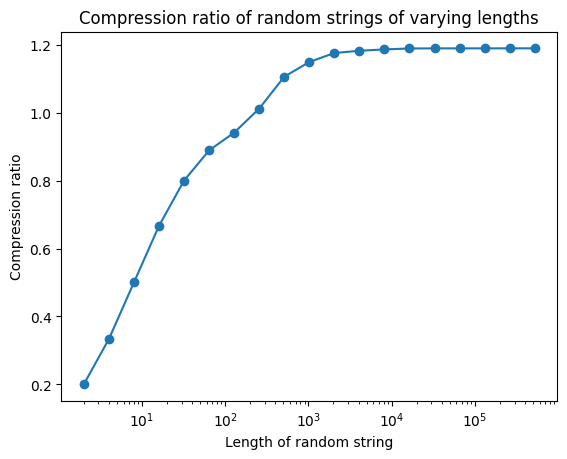

In [32]:
import zlib
import string
import random

def get_compression_ratio_of_random_string(length_of_string):
    """Generates a random string and returns its compression ratio using zlib."""
    random_string = (''.join(random.choices(string.printable, k=length_of_string))).encode('utf-8')
    compressed_string = zlib.compress(random_string)
    compression_ratio = len(random_string) / len(compressed_string)
    return compression_ratio

# plot the compression ratio of random strings of varying lengths
string_lengths = [2**i for i in range(1, 20)]
compression_ratios = [get_compression_ratio_of_random_string(length) for length in string_lengths]

plt.plot(string_lengths, compression_ratios, marker='o')
plt.xscale('log')
plt.xlabel('Length of random string')
plt.ylabel('Compression ratio')
plt.title('Compression ratio of random ascii strings of varying lengths')
plt.show()